In [5]:
import matplotlib.pyplot as plt

from maploc.demo import Demo
from maploc.osm.viz import GeoPlotter
from maploc.osm.tiling import TileManager
from maploc.osm.viz import Colormap, plot_nodes
from maploc.utils.viz_2d import plot_images

# Increasing the number of rotations increases the accuracy but requires more GPU memory.
# The highest accuracy is achieved with num_rotations=360
# but num_rotations=64~128 is often sufficient.
# To reduce the memory usage, we can reduce the tile size in the next cell.
demo = Demo(num_rotations=256, device="cpu")

[2024-04-18 14:48:52 maploc INFO] Using (roll, pitch) (-3.349483013153076, -1.4459909200668335).
[2024-04-18 14:48:53 maploc INFO] Using prior address 'ETH CAB, 6a, Universitätstrasse, Oberstrass, Kreis 6, Zürich, Bezirk Zürich, Zürich, 8092, Schweiz/Suisse/Svizzera/Svizra'


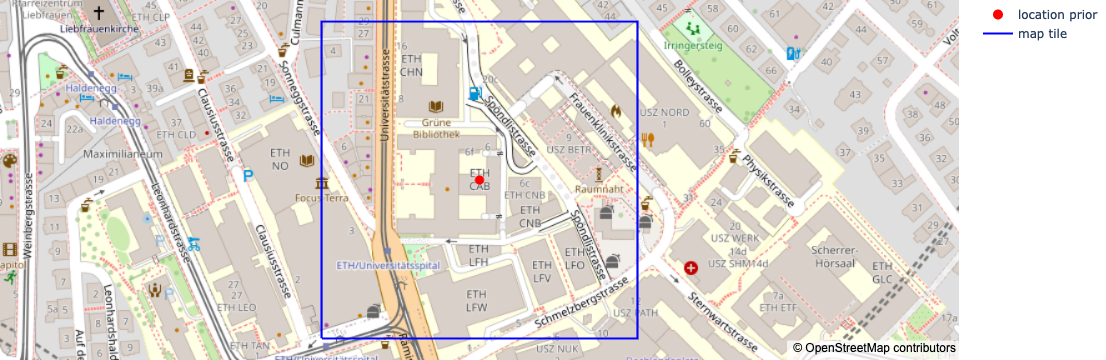

[2024-04-18 14:48:53 maploc INFO] Calling the OpenStreetMap API...


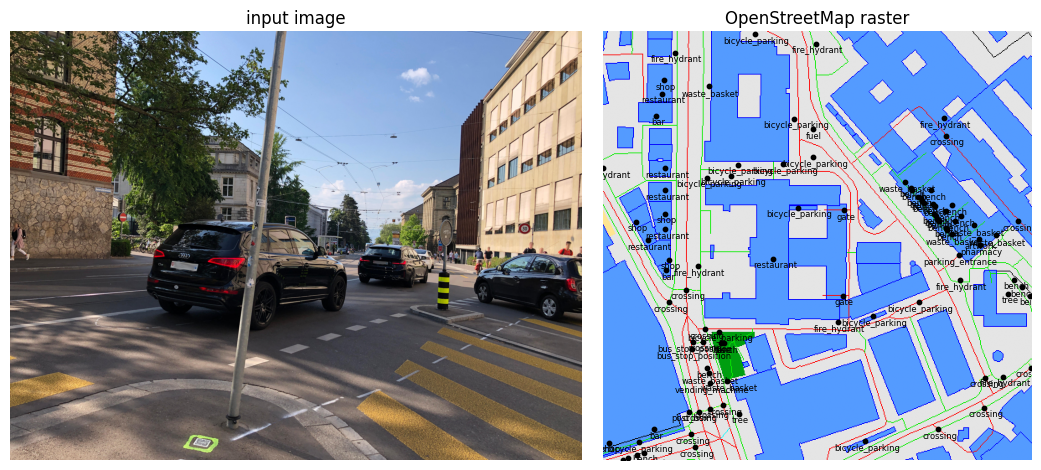

In [6]:
# no EXIF data: provide a coarse location prior as address
image_path = "assets/query_zurich_1.JPG"
prior_address = "ETH CAB Zurich"

# Try out these other queries!
# image_path = "assets/query_vancouver_1.JPG"
# prior_address = "Vancouver Waterfront Station"

# image_path = "assets/query_vancouver_2.JPG"
# image_path = "assets/query_vancouver_3.JPG"
# prior_address = None # here we load the location prior from the exif

image, camera, gravity, proj, bbox = demo.read_input_image(
    image_path,
    prior_address=prior_address,
    tile_size_meters=128,  # try 64, 256, etc.
)

# Show the query area in an interactive map
plot = GeoPlotter(zoom=16)
plot.points(proj.latlonalt[:2], "red", name="location prior", size=10)
plot.bbox(proj.unproject(bbox), "blue", name="map tile")
plot.fig.show()

# Query OpenStreetMap for this area
tiler = TileManager.from_bbox(proj, bbox + 10, demo.config.data.pixel_per_meter)
canvas = tiler.query(bbox)

# Show the inputs to the model: image and raster map
map_viz = Colormap.apply(canvas.raster)
plot_images([image, map_viz], titles=["input image", "OpenStreetMap raster"])
plot_nodes(1, canvas.raster[2], fontsize=6, size=10)

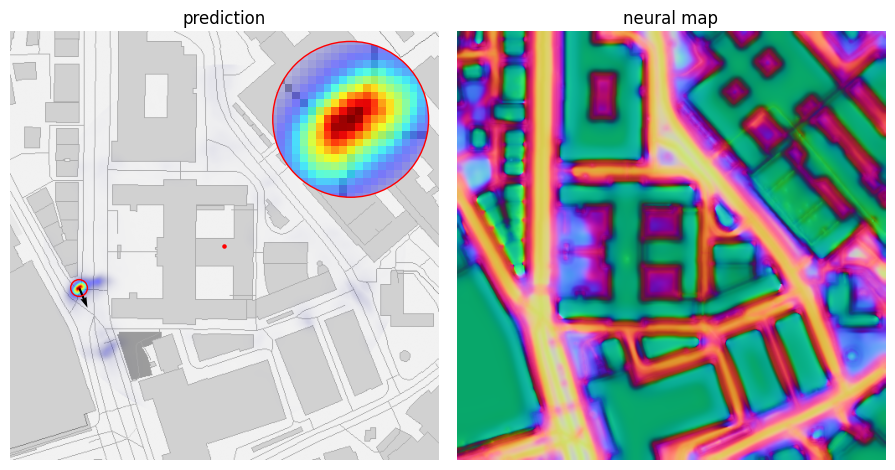

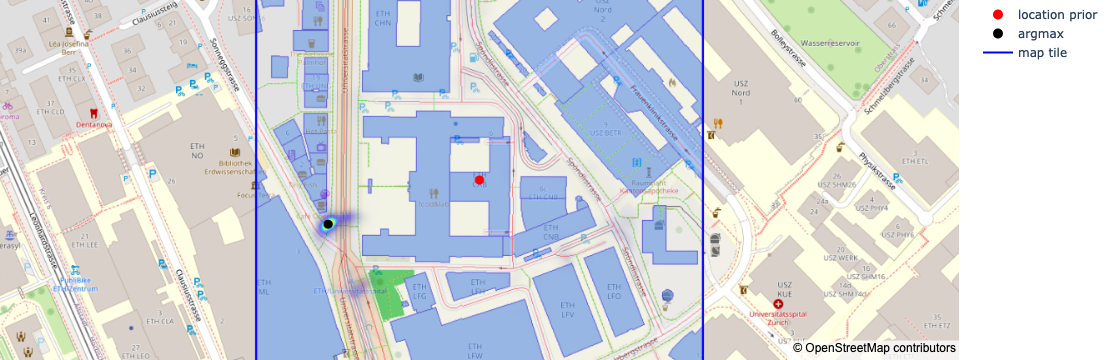

In [7]:
from maploc.utils.viz_localization import (
    likelihood_overlay,
    plot_dense_rotations,
    add_circle_inset,
)
from maploc.utils.viz_2d import features_to_RGB

# Run the inference
uv, yaw, prob, neural_map, image_rectified = demo.localize(
    image, camera, canvas, gravity=gravity
)

# Visualize the predictions
overlay = likelihood_overlay(prob.numpy().max(-1), map_viz.mean(-1, keepdims=True))
(neural_map_rgb,) = features_to_RGB(neural_map.numpy())
plot_images([overlay, neural_map_rgb], titles=["prediction", "neural map"])
ax = plt.gcf().axes[0]
ax.scatter(*canvas.to_uv(bbox.center), s=5, c="red")
plot_dense_rotations(ax, prob, w=0.005, s=1 / 25)
add_circle_inset(ax, uv)
plt.show("notebook")

# Plot as interactive figure
bbox_latlon = proj.unproject(canvas.bbox)
plot = GeoPlotter(zoom=16.5)
plot.raster(map_viz, bbox_latlon, opacity=0.5)
plot.raster(likelihood_overlay(prob.numpy().max(-1)), proj.unproject(bbox))
plot.points(proj.latlonalt[:2], "red", name="location prior", size=10)
plot.points(proj.unproject(canvas.to_xy(uv)), "black", name="argmax", size=10)
plot.bbox(bbox_latlon, "blue", name="map tile")
plot.fig.show()